# COVID-19 negative binomial deaths model

This notebook fits a model using Novel Coronavirus (COVID-19) cases and deaths data by country, provided by JHU CSSE at https://github.com/CSSEGISandData/COVID-19

We begin by estimating the new deaths at each future date $t$ based on new cases declared on each previous date:

$$
\operatorname{E} \bigl[  {nd}_t  \bigr] = \sum_{i=1}^t {nc}_i  \left( 1-s \right)  Pr\bigl[ \text{ dies  at }  t \text{ } \mid \text{ } {nc}_i \bigr ]
$$

where:

&emsp; ${s}$ = probability of survival for a new case 

&emsp; ${nd}_t$ = new deaths on date $t$

&emsp; ${nc}_t$ = new cases on date $t$

The negative binomial distribution is useful to model this conditional probability. We assume that the lag between a positive test result (i.e. creating a new case) and death due to COVID-19 follows a negative binomial distribution with parameters $n$ and $p$. This can be interpreted as the probability there will be $t$ failures until the $n$-th success for $t+n$ independent and identically distributed trials, each with probability of success $p$.

We start by combining cases and deaths data from the Johns Hopkins data for a selected country.

In [55]:
import pandas as pd
import numpy as np
#country='Spain'
#country='Italy'
#country='United Kingdom'
#country='France'
#country='Switzerland'
#country='US'
#country='China'
country='US'

In [56]:
#confirmed cases in time_series_covid19_confirmed_global.csv
url_c = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
file_c = 'C:/Users/Mark/Documents/Python/code/time_series_covid19_confirmed_global.csv'
read_c = url_c #url_c or local file_c if saved already
df_c = pd.read_csv(read_c)   #global confirmed cases
df_c['Province/State'] = df_c['Province/State'].fillna('ALL')
df_cc = df_c.loc[(df_c['Country/Region']==country) & (df_c['Province/State']=='ALL')]
df_cc = df_cc.T; df_cc.columns=['cases']
df_cc = df_cc.iloc[4:]
df_cc.index = pd.to_datetime(df_cc.index)

In [57]:
#deaths in time_series_covid19_deaths_global.csv
url_d = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
file_d = 'C:/Users/Mark/Documents/Python/code/time_series_covid19_deaths_global.csv'
read_d = url_d #url_d or local file_d if saved already
df_d = pd.read_csv(read_d)   #global confirmed cases
df_d['Province/State'] = df_d['Province/State'].fillna('ALL')
df_dc = df_d.loc[(df_d['Country/Region']==country) & (df_d['Province/State']=='ALL')]
df_dc = df_dc.T; df_dc.columns=['deaths']
df_dc = df_dc.iloc[4:]
df_dc.index = pd.to_datetime(df_dc.index)
#print(df_dc)

In [58]:
df = pd.concat([df_cc,df_dc], axis=1, sort=False)
df['country'] = country
df = df[['country','cases','deaths']]

The 5 most recent days published are:

In [59]:
print(df.tail(5))

           country   cases deaths
2020-04-09      US  461437  16478
2020-04-10      US  496535  18586
2020-04-11      US  526396  20463
2020-04-12      US  555313  22020
2020-04-13      US  580619  23529


We calculate the rate of new cases

In [60]:
df['new_deaths'] = df['deaths']-df['deaths'].shift(1)
df['new_cases'] = df['cases']-df['cases'].shift(1)
df.at[df.index[0],'new_deaths']=df.loc[df.index[0],'deaths']
df.at[df.index[0],'new_cases']=df.loc[df.index[0],'cases']
df['new_cases_rate'] = df['new_cases'] / (0.5*df['cases'].shift(1)+0.5*df['cases']+1e-10)
df.at[df.index[0],'new_cases_rate']=0.0

In [61]:
df.tail(5)

,country,cases,deaths,new_deaths,new_cases,new_cases_rate
2020-04-09,US,461437,16478,1783,32385,0.0727353
2020-04-10,US,496535,18586,2108,35098,0.0732756
2020-04-11,US,526396,20463,1877,29861,0.0583832
2020-04-12,US,555313,22020,1557,28917,0.0534654
2020-04-13,US,580619,23529,1509,25306,0.0445555


We can see the downward trend we are hoping for as measures like the lockdown take effect. 

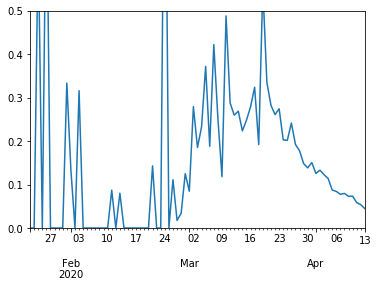

In [62]:
df['new_cases_rate'].plot( ylim=(0,0.5))

This is very noisy data! For now we assume no new cases and project deaths resulting from existing cases only. Even this is a challenge, although the negative binomial model does help.

The cases and deaths data each have their own pros and cons:
* *Cases data* leads deaths data, but it has a high margin of error due to false positives and negatives and limited coverage of the population at risk; while
* *Deaths data* lags cases data, but it has a low margin of error. The sources of 'error' in modeling terms are misclassification of cause of death and deaths ascribed to COVID-19 but not previously tested.   

By modeling the combinations of cases and deaths we hope to eliminate some of both of these sources of noise and get a better read on the underlying trend of new infections.

We assume that a new case has a daily probability $s$ of survival given tests positive for COVID-19 and a negative binomial distribution for the time to death if the new case does not survive. The  mean time until death is $\frac{n(1-p)}{p}$ for negative binomial parameters $n$ and $p$. The three parameters $s$,$p$ amd $n$ are fitted from each country's experience using least squares.

To do this, we import our COVID19 module fit and projection functions to apply to our DataFrame **df** of experience. 

In [63]:
#import our COVID19 module to access fit and projection functions to apply to our Data
from COVID19 import fit_err, fit_model, projection_df
#import functions for negative binomial model from scipy module
from scipy.stats import nbinom

We fit the model at each date and report the results, looking for trends in survival rates and $ E \left [ \text{days to death} | \text{new infection} \right ] $

In [64]:
bounds_tuple = ((0.1,0.99),(0.1,0.9),(1.0,100.0))   #we use these bounds respectively for s, p, n 
max_iterations = 50
init_params_tuple = (0.5,0.35,7.0)

start_loc = 30 #pointless fitting 3 parameters to less than 30 data points
end_loc = df.shape[0]

for i in range(start_loc, end_loc):
    fit_df = df.iloc[:i]
    res=fit_model(initparams=init_params_tuple, hyperparams=fit_df, bounds=bounds_tuple, maxiter=max_iterations)
    s,p,n=res[0]
    mean = nbinom.mean(n, p) #n*p/(1-p)
    print(df.index[i].strftime('%Y-%m-%d'),'parameters=',res[0],',',round(mean,1),'days to death,', round(res[1],0),'error')
    init_params_tuple = res[0]
    s,p,n = res[0]
    df.at[df.index[i],'s']=s
    df.at[df.index[i],'p']=p
    df.at[df.index[i],'n']=n

2020-02-21 parameters= [0.99       0.1        7.11035837] , 64.0 days to death, 0.0 error
2020-02-22 parameters= [0.99       0.1        7.11035837] , 64.0 days to death, 0.0 error
2020-02-23 parameters= [0.99       0.1        7.11035837] , 64.0 days to death, 0.0 error
2020-02-24 parameters= [0.99       0.1        7.11035837] , 64.0 days to death, 0.0 error
2020-02-25 parameters= [0.99       0.1        7.11035837] , 64.0 days to death, 0.0 error
2020-02-26 parameters= [0.99       0.1        7.11035837] , 64.0 days to death, 0.0 error
2020-02-27 parameters= [0.99       0.1        7.11035837] , 64.0 days to death, 0.0 error
2020-02-28 parameters= [0.99       0.1        7.11035837] , 64.0 days to death, 0.0 error
2020-02-29 parameters= [0.99       0.1        7.11035837] , 64.0 days to death, 0.0 error
2020-03-01 parameters= [0.68882758 0.16111053 7.3291904 ] , 38.2 days to death, 1.0 error
2020-03-02 parameters= [ 0.1         0.5785719  59.08947499] , 43.0 days to death, 1.0 error
2020-03

the negative binomial model projected for 183 days accounts for 100.0 % of future deaths
mean days to death for those who do not survive = 6.7 days

1984 max deaths expected on 2020-04-14



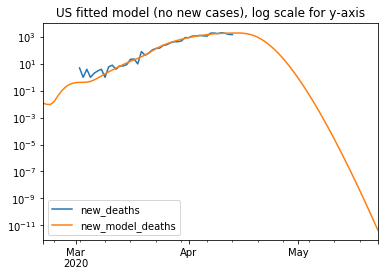

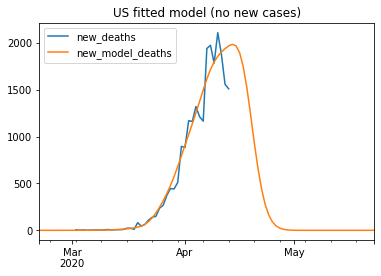

In [65]:
#plot the projection for the model (fitted from lockdown), extending the df index 100 days into the future
proj_df = projection_df(params=res[0], df=df, cases_growth_rate=0)

proj_df['new_deaths'] = proj_df['new_deaths'].replace(0.0, np.nan) #don't plot zero values

s,p,n = res[0]
#mean = n*(1/p - 1) = n*(1-p)/p ##C:\ProgramData\Anaconda3\Lib\site-packages\scipy\stats\_discrete_distns.py line 210
mean = nbinom.mean(n, p) 
print('mean days to death for those who do not survive =',round(mean,1),'days')

proj_df[['new_deaths','new_model_deaths']].iloc[30:-60].plot(title=country+' fitted model (no new cases), log scale for y-axis', logy=True)
proj_df[['new_deaths','new_model_deaths']].iloc[30:-60].plot(title=country+' fitted model (no new cases)')

loc_max = proj_df.loc[ proj_df['new_model_deaths'] == proj_df['new_model_deaths'].max()].index[0]
print()
print(int(round(proj_df['new_model_deaths'].max(),0)),'max deaths expected on',loc_max.strftime('%Y-%m-%d'))
print()


Our deaths projection may give a cleaner indication of the trend in infections. 

Here are the rates of new deaths for last 15 days:

In [66]:
proj_df['new model deaths rate'] = proj_df['new_model_deaths']/proj_df['deaths']
print(proj_df.tail(115).head(15))

           country   cases  deaths  new_deaths  new_cases  new_cases_rate  \
2020-03-30      US  161831    2978       511.0    20922.0        0.138218   
2020-03-31      US  188172    3873       895.0    26341.0        0.150519   
2020-04-01      US  213372    4757       884.0    25200.0        0.125516   
2020-04-02      US  243762    5926      1169.0    30390.0        0.132959   
2020-04-03      US  275586    7087      1161.0    31824.0        0.122554   
2020-04-04      US  308853    8407      1320.0    33267.0        0.113843   
2020-04-05      US  337072    9619      1212.0    28219.0        0.087375   
2020-04-06      US  366667   10783      1164.0    29595.0        0.084108   
2020-04-07      US  396223   12722      1939.0    29556.0        0.077484   
2020-04-08      US  429052   14695      1973.0    32829.0        0.079559   
2020-04-09      US  461437   16478      1783.0    32385.0        0.072735   
2020-04-10      US  496535   18586      2108.0    35098.0        0.073276   

One idea would be to project future deaths straight from this smoothed trend and compare it against a projection of deaths resulting from assumed new cases.